In [3]:
import netCDF4
from netCDF4 import Dataset
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
%matplotlib inline

In [4]:
#https://www.drought.gov/drought/data-maps-tools
#ftp://ftp.star.nesdis.noaa.gov/pub/corp/scsb/wguo/data/Blended_VH_4km/VH/
#https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH_doc/VHP_uguide_v2.0_2018_0727.pdf

In [5]:
fNetCDF = netCDF4.Dataset('VHP.G04.C07.npp.P2019018.VH.nc')

fNetCDF.set_auto_mask(False) 
print(fNetCDF.variables.keys())
vhi = fNetCDF.variables['VHI']
print(fNetCDF.variables['VHI'])
print(vhi[:])

odict_keys(['VCI', 'TCI', 'VHI', 'QA', 'latitude', 'longitude', 'PLATE_CARREE'])
<class 'netCDF4._netCDF4.Variable'>
int16 VHI(HEIGHT, WIDTH)
    long_name: Vegetation Health Index
    grid_mapping: PLATE_CARREE
    units: 
    valid_range: [  0. 100.]
    _FillValue: -999
    scale_factor: 0.01
    add_offset: 0.0
    Remark:  science_data = packed_data * scale_factor + add_offset
unlimited dimensions: 
current shape = (3616, 10000)
filling on
[[-9.99 -9.99 -9.99 ... -9.99 -9.99 -9.99]
 [-9.99 -9.99 -9.99 ... -9.99 -9.99 -9.99]
 [-9.99 -9.99 -9.99 ... -9.99 -9.99 -9.99]
 ...
 [-9.99 -9.99 -9.99 ... -9.99 -9.99 -9.99]
 [-9.99 -9.99 -9.99 ... -9.99 -9.99 -9.99]
 [-9.99 -9.99 -9.99 ... -9.99 -9.99 -9.99]]


In [6]:
#plt.imshow(vhi, cmap='YlGn', interpolation='nearest')
#plt.show()
#plt.imshow(vhi[900:1200,1500:1800], cmap='YlGn', interpolation='nearest')
#plt.show()

In [7]:
#filename = "vhi data 4km superset around california.csv"
#f= open(filename,"w")
#f.write("Longitude:, -124.182, -115.182\n") 
#f.write("Latitude:, 42.606, 31.806\n") 
#for i in vhi[900:1200,1500:1800]:
#    for j in i:
#        f.write(str(j))
#        f.write(",")
#    f.write("\n")
#f.close()

In [8]:
def rowsToLatitude(j):
    float(j)
    dLat = ((55.152+75.024)/3616.0)
    latitude  = (75.024 - (j+0.5) * dLat) #(j: counts from 0 to 3615) 
    return latitude
    
    #
def columnsToLongitude(i):
    float(i)
    dLon= (360.0/10000.0)
    longitude = (-180.0 + (i+0.5) * dLon)  #(i: counts from 0 to 9999)
    return longitude

def latitudeToRows(latitude):
    inverse_dLat = (3616.0/(55.152+75.024))
    row = (-(latitude-75.024)*inverse_dLat + 0.5 ) -1
    return int(np.round(row,0))
    
def longitudeToColumns(longitude):
    inverse_dLon= (10000.0/360.0)
    column = (longitude+180)*inverse_dLon-0.5
    return int(np.round(column,0))

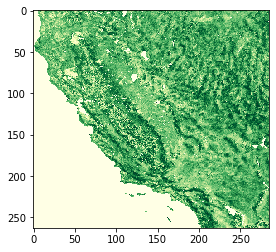

latNorthrow  917
latSouthrow  1180
longWestcol  1544
longEastcol  1829


In [9]:
# Max Latitude    42.009246999999995  Min Latitude   32.534155999999996
# Max Longitude  -114.139055          Min Longitude  -124.409591

latNorthrow= latitudeToRows(42.009246999999995)
latSouthrow= latitudeToRows(32.534155999999996)
longWestcol= longitudeToColumns(-124.409591)
longEastcol= longitudeToColumns(-114.139055)

plt.imshow(vhi[latNorthrow:latSouthrow,longWestcol:longEastcol], cmap='YlGn', interpolation='nearest')
plt.show()

print("latNorthrow ", latNorthrow)
print("latSouthrow ", latSouthrow)
print("longWestcol ", longWestcol)
print("longEastcol ", longEastcol)

In [10]:
filename = "California_Mainland_Boundaries.csv"
california_boundaries = genfromtxt(filename, delimiter=',')
california_boundaries_as_rows_and_columns = np.empty([412,2])

for rowNum,row in enumerate(california_boundaries):
    california_boundaries_as_rows_and_columns[rowNum,0]= latitudeToRows(row[0])
    california_boundaries_as_rows_and_columns[rowNum,1]= longitudeToColumns(row[1])

california_boundaries_as_rows_and_columns= california_boundaries_as_rows_and_columns.astype("int64")

#latNorthrow  917
#latSouthrow  1180
#longWestcol  1544
#longEastcol  1829

cali_boundaries_plot_points = np.empty([412,2],dtype="int64")
cali_boundaries_plot_points[:,0] = california_boundaries_as_rows_and_columns[:,0]-917
cali_boundaries_plot_points[:,1] = california_boundaries_as_rows_and_columns[:,1]-1544

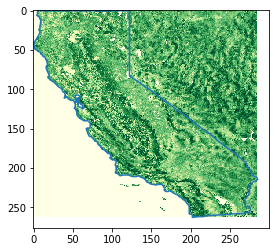

In [11]:
plt.imshow(vhi[latNorthrow:latSouthrow,longWestcol:longEastcol], cmap='YlGn', interpolation='nearest')
plt.plot(cali_boundaries_plot_points[:,1],cali_boundaries_plot_points[:,0], 'tab:blue')
plt.show()

In [12]:
#https://stackoverflow.com/questions/43892459/check-if-geo-point-is-inside-or-outside-of-polygon/43897516#43897516
lons_lats_vect = np.column_stack((california_boundaries[:,1], california_boundaries[:,0])) # Reshape coordinates
polygon = Polygon(lons_lats_vect) # create polygon

lat_diff = 1180-917 #latNorthrow  917 latSouthrow  1180  # value of variable 263
long_diff = 1829-1544 #longWestcol  1544 longEastcol  1829 # value of variable 285

vegitation_health_index_data = np.empty([lat_diff, long_diff], dtype = "int64")

for lat_row in range(lat_diff):
    for long_column in range(long_diff):
        test_lat = rowsToLatitude(917+lat_row)
        test_long = columnsToLongitude(1544+long_column)
        point = Point(test_long,test_lat) # create point
        if(polygon.contains(point)): # tests if point is in polygon returns boolean
            if(vhi[917+lat_row,1544+long_column]==vhi[917,1544]):
                vegitation_health_index_data[lat_row,long_column] =  -1
            else:
                vegitation_health_index_data[lat_row,long_column] =  vhi[917+lat_row,1544+long_column]
        else:
            vegitation_health_index_data[lat_row,long_column] = -9

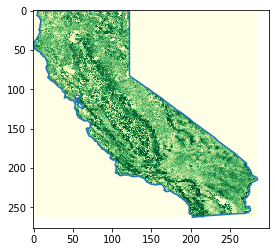

In [13]:
plt.imshow(vegitation_health_index_data, cmap='YlGn', interpolation='nearest')
plt.plot(cali_boundaries_plot_points[:,1],cali_boundaries_plot_points[:,0], 'tab:blue')
plt.show()

In [14]:
#vegitation_health_index_data[0:50,0:50]

In [15]:
islands_bound_list = []

for i in range(5):
    filename=("California_Island_Boundaries_%d.csv" %(i))
    island_bound = genfromtxt(filename, delimiter=',')
    island_bound_rows_columns = np.empty([np.size(island_bound,0),2])

    for rowNum,row in enumerate(island_bound):
        island_bound_rows_columns[rowNum,0]= latitudeToRows(row[0])
        island_bound_rows_columns[rowNum,1]= longitudeToColumns(row[1])

    island_bound_rows_columns= island_bound_rows_columns.astype("int64")

    island_bound_points = np.empty([np.size(island_bound,0),2],dtype="int64")
    island_bound_points[:,0] = island_bound_rows_columns[:,0]-917 # latNorthrow 917 
    island_bound_points[:,1] = island_bound_rows_columns[:,1]-1544 # longWestcol 1544 
    islands_bound_list.append(island_bound_points)

    lons_lats_vect = np.column_stack((island_bound[:,1], island_bound[:,0])) # Reshape coordinates
    polygon = Polygon(lons_lats_vect) # create polygon

    lat_diff = 1180-917 #latNorthrow  917 latSouthrow  1180
    long_diff = 1829-1544 #longWestcol  1544 longEastcol  1829
    #vegitation_health_index_data = np.empty([lat_diff, long_diff], dtype = "int64")

    for lat_row in range(lat_diff):
        for long_column in range(long_diff):
            test_lat = rowsToLatitude(917+lat_row)
            test_long = columnsToLongitude(1544+long_column)
            point = Point(test_long,test_lat) # create point
            if(polygon.contains(point)): # tests if point is in polygon returns boolean
                if(vhi[917+lat_row,1544+long_column]==vhi[917,1544]):
                    vegitation_health_index_data[lat_row,long_column] =  -1
                else:
                    vegitation_health_index_data[lat_row,long_column] =  vhi[917+lat_row,1544+long_column]


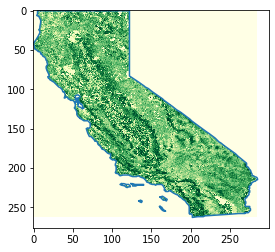

In [16]:
plt.imshow(vegitation_health_index_data, cmap='YlGn', interpolation='nearest')
plt.plot(cali_boundaries_plot_points[:,1], cali_boundaries_plot_points[:,0], 'tab:blue')
for i in range(5):
    plt.plot(islands_bound_list[i][:,1],islands_bound_list[i][:,0], 'tab:blue')
plt.plot()
plt.show()

In [17]:
vegitation_health_index_data
filename = "vegitation_health_index_4km_2019_01_8.csv"
#np.savetxt(filename, vegitation_health_index_data, delimiter=",",fmt="%d")

In [21]:
print(np.amax(vegitation_health_index_data))
print(np.amin(vegitation_health_index_data))

#A, B = np.partition(vegitation_health_index_data, 1)[0:2]
#print(A)  # 1
#print(B)  # 2

100
-9


In [183]:
fNetCDF.close()

In [28]:
value = 100
print(int(39 - ( (39/101)*(value+1))))
value=-1
print(int(39 - ( (39/101)*(value+1))))

0
39


In [30]:
value = 100
print(int(117 - ( (59/101)*(value+1))))
value = -1
print(int(117 - ( (59/101)*(value+1))))

58
117


In [32]:
value = 100
print(int((83 - ( (50/100)*(value+1)))))
value = -1
print(int((83 - ( (50/100)*(value+1)))))

32
83
